In [1]:
import sys

import argparse
import math
import cv2
import torch
import os
import numpy as np
import json
from tqdm import tqdm

import matplotlib.pyplot as plt

from einops import rearrange, repeat

import torchvision

# set cuda device cuda:1
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda:0")

In [2]:
sys.path.append("../")

In [3]:
import torch
from scene import Scene
import os
from tqdm import tqdm
from os import makedirs
# from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from scene.anchor_gaussian_model import GaussianModel
from gaussian_renderer import render
import numpy as np
import json


/home/zhaonan/miniconda3/envs/ag2seg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# from utils.camera_view_utils import *
# from utils.render_utils import *
from sklearn.decomposition import PCA
import colorsys


def feature_to_rgb(features):
  # Input features shape: (16, H, W)

  # Reshape features for PCA
  H, W = features.shape[1], features.shape[2]
  features_reshaped = features.view(features.shape[0], -1).T

  # Apply PCA and get the first 3 components
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(features_reshaped.cpu().numpy())

  # Reshape back to (H, W, 3)
  pca_result = pca_result.reshape(H, W, 3)

  # Normalize to [0, 255]
  pca_normalized = 255 * (pca_result - pca_result.min()) / (pca_result.max() -
                                                            pca_result.min())

  rgb_array = pca_normalized.astype('uint8')

  return rgb_array


def id2rgb(id, max_num_obj=256):
  if not 0 <= id <= max_num_obj:
    raise ValueError("ID should be in range(0, max_num_obj)")

  # Convert the ID into a hue value
  golden_ratio = 1.6180339887
  h = ((id * golden_ratio) % 1)  # Ensure value is between 0 and 1
  s = 0.5 + (id % 2) * 0.5  # Alternate between 0.5 and 1.0
  l = 0.5

  # Use colorsys to convert HSL to RGB
  rgb = np.zeros((3,), dtype=np.uint8)
  if id == 0:  #invalid region
    return rgb
  r, g, b = colorsys.hls_to_rgb(h, l, s)
  rgb[0], rgb[1], rgb[2] = int(r * 255), int(g * 255), int(b * 255)

  return rgb


def visualize_obj(objects):
  rgb_mask = np.zeros((*objects.shape[-2:], 3), dtype=np.uint8)
  all_obj_ids = np.unique(objects)
  for id in all_obj_ids:
    colored_mask = id2rgb(id)
    rgb_mask[objects == id] = colored_mask
  return rgb_mask


def add_star_point(point, star_size=500, color='red'):
  plt.scatter(point[:, 0],
              point[:, 1],
              s=star_size,
              c=color,
              marker='*',
              edgecolors='white',
              linewidths=1.25)


def get_pixel_at_star(image, point):
  # point: (n,2)
  res = []
  for p in point:
    res.append(image[int(p[1]), int(p[0])])
  return res


def save_rgb_image(img_tensor, save_path):
  """
  img_tensor: (3,h,w)
  save_path: str
  """
  torchvision.utils.save_image(img_tensor, save_path)
  print(f"Save image to {save_path}")

In [5]:
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")
# args = get_combined_args(parser)
# print(parser)


_StoreTrueAction(option_strings=['--quiet'], dest='quiet', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [ ]:
sys.argv = [
    "run_in_ipynb",
    "-m",
    "../outputs/lerf_test2/figurines",
]
args = get_combined_args(parser)

Looking for config file in ../outputs/lerf_test2/figurines/cfg_args
Config file found: ../outputs/lerf_test2/figurines/cfg_args


In [7]:
from utils.log_utils import *
with torch.no_grad():
  dataset = model.extract(args)
  gaussians = GaussianModel(dataset.sh_degree,
                            init_child_num=5,
                            use_free_scale=dataset.use_free_scale,
                            logger=get_loguru_logger())
  scene = Scene(dataset, gaussians, load_iteration=35_000, shuffle=False)
  gaussians.GraphHelper.eval()

2025-11-24 12:33:31.243 | INFO     | scene.anchor_gaussian_model:__init__:110 - use free scale: True
2025-11-24 12:33:31.245 | INFO     | scene.anchor_gaussian_model:setup_functions:50 - Using free scaling


2025-11-24 12:33:31.257 | INFO     | scene.anchor_gaussian_model:__init__:174 - Using free scale
2025-11-24 12:33:31.522 | INFO     | scene.anchor_gaussian_model:_init_loss:190 - Using free scale loss
2025-11-24 12:33:31.523 | INFO     | scene.utils.loss_helper:append:20 - Append loss function children_in_anchor_loss with weight 0.5.
2025-11-24 12:33:31.524 | INFO     | scene.utils.loss_helper:append:20 - Append loss function graph_loss with weight 0.01.


Loading trained model at iteration 35000
Reading camera 303/303 name: frame_00260.jpg
Loading Training Cameras


Loading cameras: 303it [00:10, 27.76it/s]


Loading Test Cameras


Loading cameras: 0it [00:00, ?it/s]
/home/zhaonan/gs/ag2_release/scripts/../scene/anchor_gaussian_model.py:598: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (data, opt) = t

In [8]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
background_w = torch.tensor([1, 1, 1], dtype=torch.float32, device="cuda")
print("background color is", "white" if dataset.white_background else "black")
train_views = scene.getTrainCameras()
test_views = scene.getTestCameras()
print("train views number", len(train_views))
print("test views number", len(test_views))

background color is black
train views number 303
test views number 0


view name frame_00008


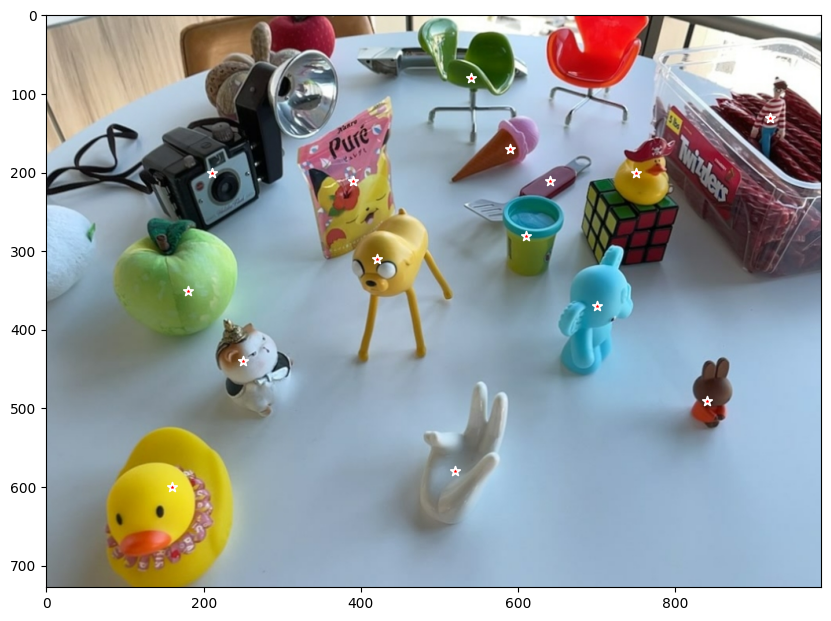

Save image to figurines_test.png


In [ ]:
target_view = train_views[7]
print(f"view name {target_view.image_name}")
# target_view = train_views[260]
# target_view = test_views[-1]
with torch.no_grad():
  rendering = render(target_view, gaussians, pipeline, background)
  image = rendering["render"]

# point = np.array([[400, 280], [380, 180], [100, 300], [680, 360], [100, 600]])
point = np.array([
    [160, 600],
    [180, 350],
    [250, 440],
    [390, 210],
    [420, 310],
    [520, 580],
    [210, 200],
    [610, 280],
    [590, 170],
    [640, 210],
    [700, 370],
    [750, 200],
    [840, 490],
    [920, 130],
    [540, 80],
])

plt.figure(figsize=(10, 10))
plt.imshow(torchvision.transforms.ToPILImage()(
    target_view.original_image.cpu()))
add_star_point(point, 50)
# hidden aixs
# plt.axis("off")
plt.show()
plt.close()

# save_rgb_image(image, "figurines_test.png")

[tensor([-0.3890, -0.1850, -0.9025], device='cuda:0'), tensor([-8.5411e-01, -5.2009e-01, -3.4527e-04], device='cuda:0'), tensor([-0.2923,  0.6730,  0.6794], device='cuda:0'), tensor([-0.7823,  0.3235, -0.5323], device='cuda:0'), tensor([ 0.2920, -0.6929, -0.6592], device='cuda:0'), tensor([ 0.2854,  0.8511, -0.4395], device='cuda:0'), tensor([-0.9353,  0.2659,  0.2333], device='cuda:0'), tensor([ 0.7007, -0.7066, -0.0986], device='cuda:0'), tensor([-0.2500,  0.7712, -0.5798], device='cuda:0'), tensor([0.5626, 0.7665, 0.1612], device='cuda:0'), tensor([-0.0400,  0.9977,  0.0545], device='cuda:0'), tensor([-0.9048, -0.2490, -0.3455], device='cuda:0'), tensor([-0.4157, -0.9076, -0.0579], device='cuda:0'), tensor([ 0.9887, -0.0803,  0.1267], device='cuda:0'), tensor([ 0.1699, -0.1272, -0.9772], device='cuda:0')]
target obj feat is [tensor([-0.3890, -0.1850, -0.9025], device='cuda:0'), tensor([-8.5411e-01, -5.2009e-01, -3.4527e-04], device='cuda:0'), tensor([-0.2923,  0.6730,  0.6794], devi

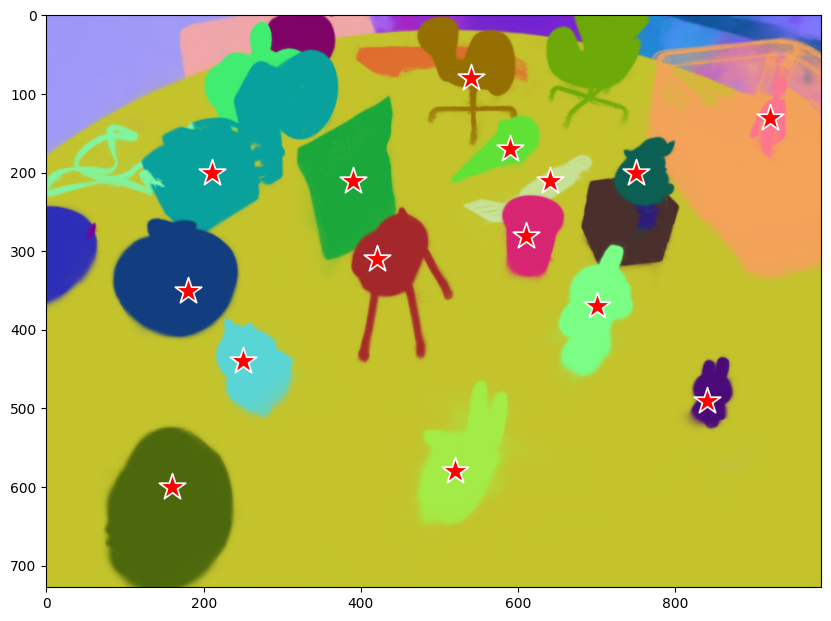

In [10]:
image_feat = rendering["feature"]

print(get_pixel_at_star(rearrange(image_feat, "f h w -> h w f"), point))

target_feat = get_pixel_at_star(rearrange(image_feat, "f h w -> h w f"), point)
print("target obj feat is", target_feat)

for i in range(len(target_feat)):
  target_feat[i] = target_feat[i].unsqueeze(0)
  print(target_feat[i].shape)
target_feat = torch.cat(target_feat, dim=0).cuda()

plt.figure(figsize=(10, 10))
plt.imshow(torchvision.transforms.ToPILImage()((image_feat * 0.5 + 0.5).cpu()))
# plt.imshow(pred_obj_gray)
add_star_point(point, 400)
plt.show()
plt.close()


[tensor([2.1353], device='cuda:0'), tensor([2.9388], device='cuda:0'), tensor([2.6673], device='cuda:0'), tensor([3.3682], device='cuda:0'), tensor([2.6667], device='cuda:0'), tensor([2.4923], device='cuda:0'), tensor([3.5762], device='cuda:0'), tensor([3.1894], device='cuda:0'), tensor([4.0945], device='cuda:0'), tensor([3.9720], device='cuda:0'), tensor([2.6141], device='cuda:0'), tensor([3.2196], device='cuda:0'), tensor([2.6117], device='cuda:0'), tensor([3.5736], device='cuda:0'), tensor([4.1667], device='cuda:0')]
torch.Size([1, 728, 986])


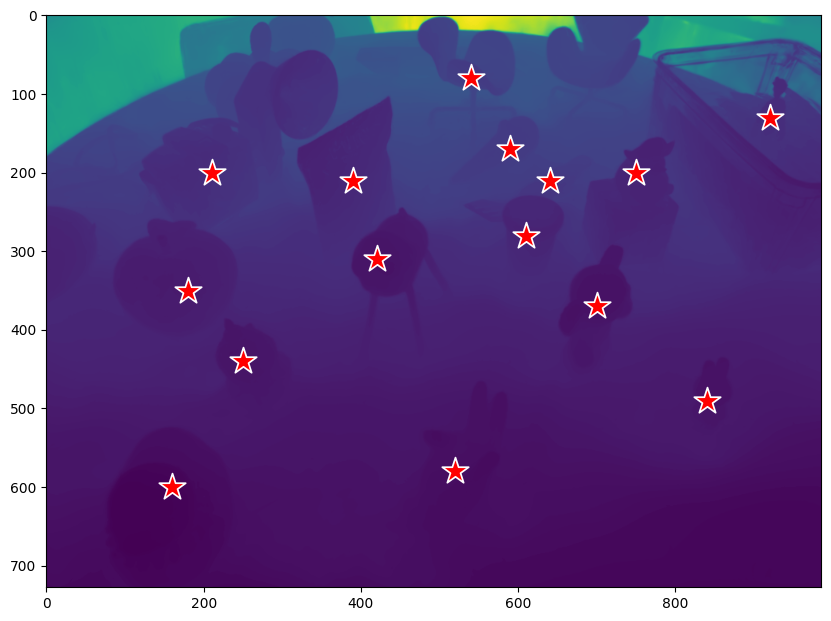

In [11]:
image_depth = rendering["depth"]
# image_depth =
target_depth = get_pixel_at_star(rearrange(image_depth, "f h w -> h w f"),
                                 point)

print(target_depth)
print(image_depth.shape)

plt.figure(figsize=(10, 10))
plt.imshow(torchvision.transforms.ToPILImage()(
    (image_depth / image_depth.max()).cpu()))
# plt.imshow(pred_obj_gray)
add_star_point(point, 400)
plt.show()
plt.close()


torch.Size([3, 728, 986])
[tensor([ 0.8433,  2.1485, -1.7584], device='cuda:0'), tensor([-0.1737,  2.1039, -1.3505], device='cuda:0'), tensor([ 0.3637,  2.1436, -1.3026], device='cuda:0'), tensor([-0.3282,  1.7676, -0.3696], device='cuda:0'), tensor([ 0.4666,  1.7090, -0.7224], device='cuda:0'), tensor([ 1.2436,  2.2538, -0.7788], device='cuda:0'), tensor([-1.0034,  1.9403, -0.9139], device='cuda:0'), tensor([0.4985, 1.7883, 0.1853], device='cuda:0'), tensor([-0.3899,  1.7806,  0.8805], device='cuda:0'), tensor([-0.0483,  1.8609,  0.9433], device='cuda:0'), tensor([ 1.1664,  1.7085, -0.0519], device='cuda:0'), tensor([0.6437, 1.4598, 0.7541], device='cuda:0'), tensor([1.6624, 1.9604, 0.2151], device='cuda:0'), tensor([0.7472, 1.2289, 1.7654], device='cuda:0'), tensor([-0.8560,  1.4633,  0.8447], device='cuda:0')]


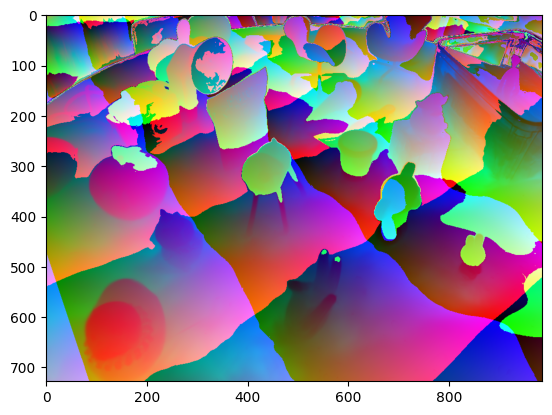

In [16]:
img_xyz = gaussians.get_points_from_depth(target_view, image_depth).reshape(
    image_depth.shape[1], image_depth.shape[2], 3)
img_xyz = rearrange(img_xyz, "h w f -> f h w")
print(img_xyz.shape)
target_xyz = get_pixel_at_star(rearrange(img_xyz, "f h w -> h w f"), point)
print(target_xyz)

for i in range(len(target_xyz)):
  target_xyz[i] = target_xyz[i].unsqueeze(0)
target_xyz = torch.cat(target_xyz, dim=0).cuda()

plt.imshow(torchvision.transforms.ToPILImage()(img_xyz.cpu()))

tensor([[ 19506,  99513,  53140],
        [ 14734,  14718, 109388],
        [ 16339,  16189,  16362],
        [ 14361,  14327,  14326],
        [351471,  17154,  27861],
        [ 21345,  21453,  21390],
        [ 10803,  10832,  10887],
        [216110,  17049,  26018],
        [ 13174,  73456,  13848],
        [246823, 177421, 161880],
        [109552,  53159,  21191],
        [ 17993,  17910,  17909],
        [ 22031,  22067,  22061],
        [ 18812,  19058,  59077],
        [ 41134,  11309, 113916]], device='cuda:0')
torch.Size([398210])
torch.Size([1529918, 1])


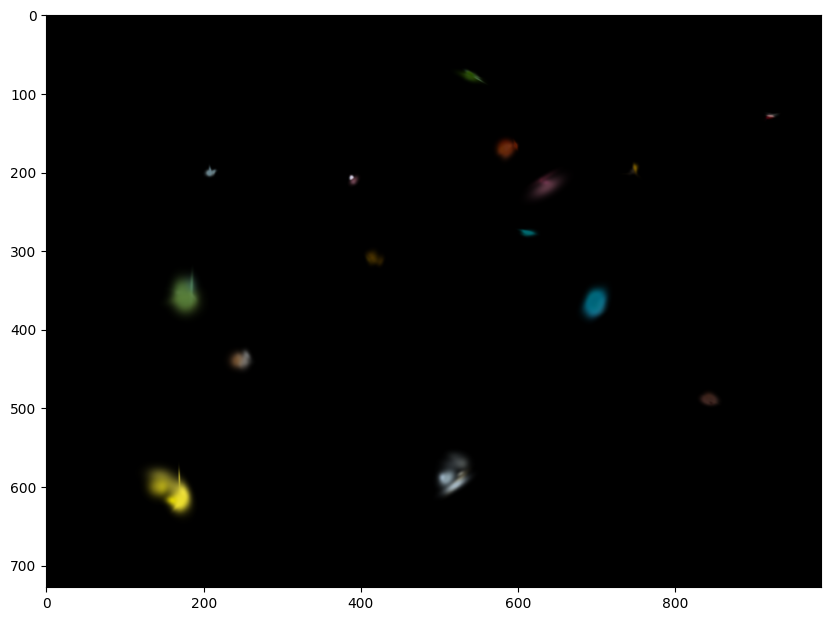

In [17]:
d, idx, k_anchor = gaussians.search_k_nearest_anchor(target_xyz, 3)

print(idx)

anchor_mask = torch.zeros(gaussians._anchor_xyz.shape[0],
                          dtype=torch.bool,
                          device=device)
anchor_mask[idx] = True

print(anchor_mask.shape)

child_mask = anchor_mask[gaussians._point2anchor].contiguous().unsqueeze(1)

print(child_mask.shape)

with torch.no_grad():
  image = render(target_view,
                 gaussians,
                 pipeline,
                 background,
                 opacity_mask=child_mask)["render"]
plt.figure(figsize=(10, 10))
plt.imshow(torchvision.transforms.ToPILImage()(image.cpu()))
plt.show()
plt.close()

In [ ]:
def debug_function(model):
  radii = model._anchor_radii.data.contiguous().half()
  return radii

In [ ]:
print(gaussians.get_voxel_size())

gaussians.GraphHelper.build_graph(edge_dist_scale=2,
                                  debug_func=debug_function,
                                  link_isolated=False)

2025-11-24 12:33:49.056 | INFO     | scene.utils.graph_baseclass:build_graph:388 - Building graph... in GraphBaseClass
2025-11-24 12:33:49.060 | INFO     | scene.utils.graph_baseclass:build_graph:419 - Mean radius torch.Size([398210, 1]) of anchor points : 0.05503508821129799
2025-11-24 12:33:49.062 | INFO     | scene.utils.graph_baseclass:build_graph:421 - Min and Max radius of anchor points : 0.0 0.06585693359375


0.004116757214069367


Building graph (knn): 100%|██████████| 195/195 [00:23<00:00,  8.27it/s]
2025-11-24 12:34:12.675 | INFO     | scene.utils.graph_baseclass:build_graph:452 - Graph built with 2246429 edges.
2025-11-24 12:34:12.677 | INFO     | scene.utils.graph_baseclass:build_graph:455 - Edges need 0.02GB gpu memory.


In [ ]:
gaussians.GraphHelper.edge_dist_scale = 2
print(gaussians.spatial_lr_scale)
try:
  del gaussians.GraphHelper.edge_weights
except:
  pass
torch.cuda.empty_cache()

6.5868115


In [23]:
def debug_edge_weights(edges):
  features = gaussians.segment_activation(gaussians._feature).detach()

  feature_dis = torch.norm(features[edges[:, 0]] - features[edges[:, 1]],
                           dim=1,
                           keepdim=True)  # (m, 1)
  return feature_dis


gaussians.GraphHelper.edge_weights = gaussians.GraphHelper.compute_all_edge_weight(
    debug_edge_weights).squeeze(1)

2025-11-24 12:34:12.722 | INFO     | scene.utils.graph_baseclass:compute_all_edge_weight:593 - Computing all edge weight...


2025-11-24 12:34:12.755 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 0 selected 4493 edges, 1917 anchors
2025-11-24 12:34:12.757 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 1 selected 141302 edges, 3229 anchors


2025-11-24 12:34:12.759 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 2 selected 292341 edges, 2438 anchors
2025-11-24 12:34:12.762 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 3 selected 397884 edges, 2003 anchors
2025-11-24 12:34:12.764 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 4 selected 478366 edges, 1307 anchors
2025-11-24 12:34:12.766 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 5 selected 524942 edges, 691 anchors
2025-11-24 12:34:12.769 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 6 selected 547026 edges, 473 anchors
2025-11-24 12:34:12.771 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 7 selected 573534 edges, 335 anchors
2025-11-24 12:34:12.773 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 8 sel

torch.Size([1529918, 1])


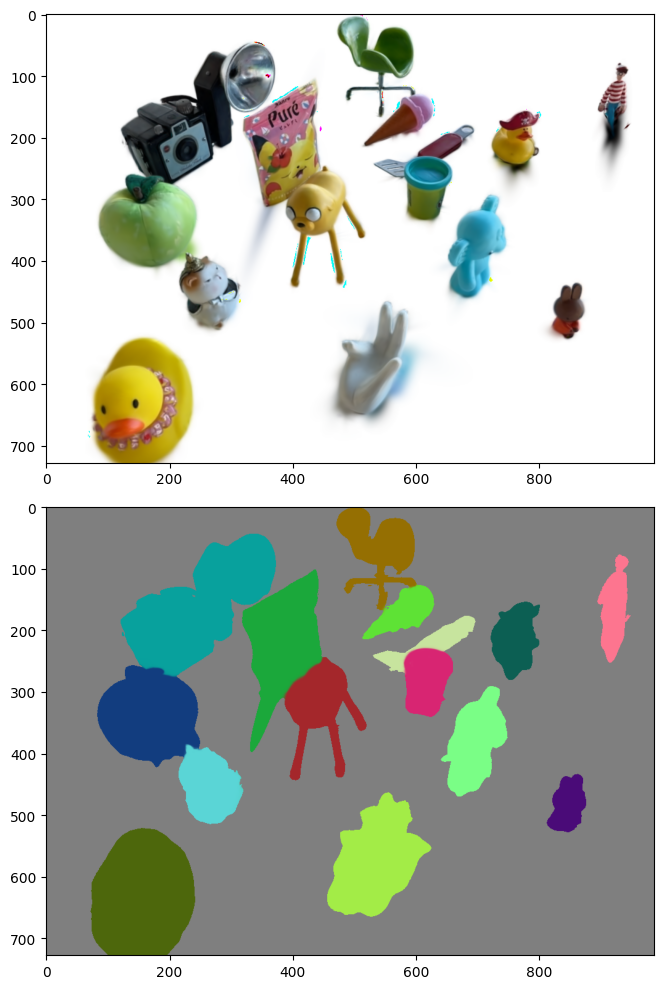

Save image to figurines_select_rgb.png
Save image to figurines_select_semantic.png


In [ ]:
selected_edges, selected_anchor = gaussians.GraphHelper.select_edges(
    idx,
    edge_weight_threshold=0.10,
    iter_num=50,
    edge_select_condition=lambda ew, threshold: ew < threshold,
    big_anchor_mask=None)

child_mask = selected_anchor[gaussians._point2anchor].contiguous().unsqueeze(1)

print(child_mask.shape)

with torch.no_grad():
  r_pkg = render(target_view,
                 gaussians,
                 pipeline,
                 background_w,
                 opacity_mask=child_mask)
  image = r_pkg["render"]
  img_semantic = r_pkg["feature"]

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(torchvision.transforms.ToPILImage()(image.cpu()))
plt.subplot(2, 1, 2)
plt.imshow(torchvision.transforms.ToPILImage()(
    (img_semantic * 0.5 + 0.5).cpu()))
plt.tight_layout()
plt.show()

# save_rgb_image(image, "figurines_select_rgb.png")
# save_rgb_image((img_semantic * 0.5 + 0.5), "figurines_select_semantic.png")

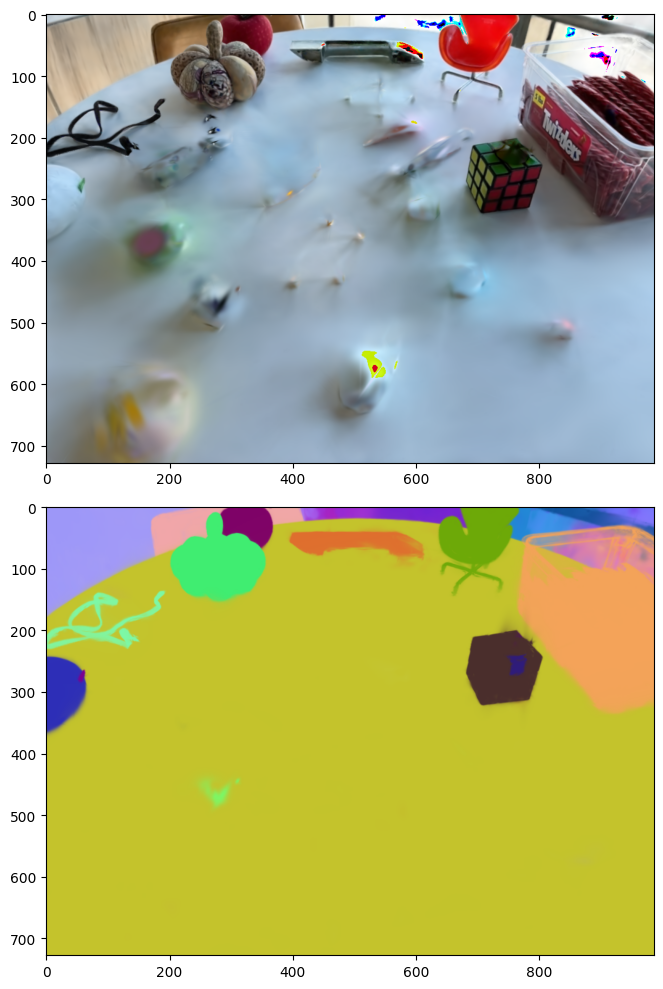

Save image to figurines_removal_rgb.png
Save image to figurines_removal_semantic.png


In [25]:
with torch.no_grad():
  r_pkg = render(target_view,
                 gaussians,
                 pipeline,
                 background,
                 opacity_mask=~child_mask)
  image = r_pkg["render"]
  img_semantic = r_pkg["feature"]

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(torchvision.transforms.ToPILImage()(image.cpu()))
plt.subplot(2, 1, 2)
plt.imshow(torchvision.transforms.ToPILImage()((img_semantic * .5 + .5).cpu()))
plt.tight_layout()
plt.show()

save_rgb_image(image, "figurines_removal_rgb.png")
save_rgb_image((img_semantic * 0.5 + 0.5), "figurines_removal_semantic.png")

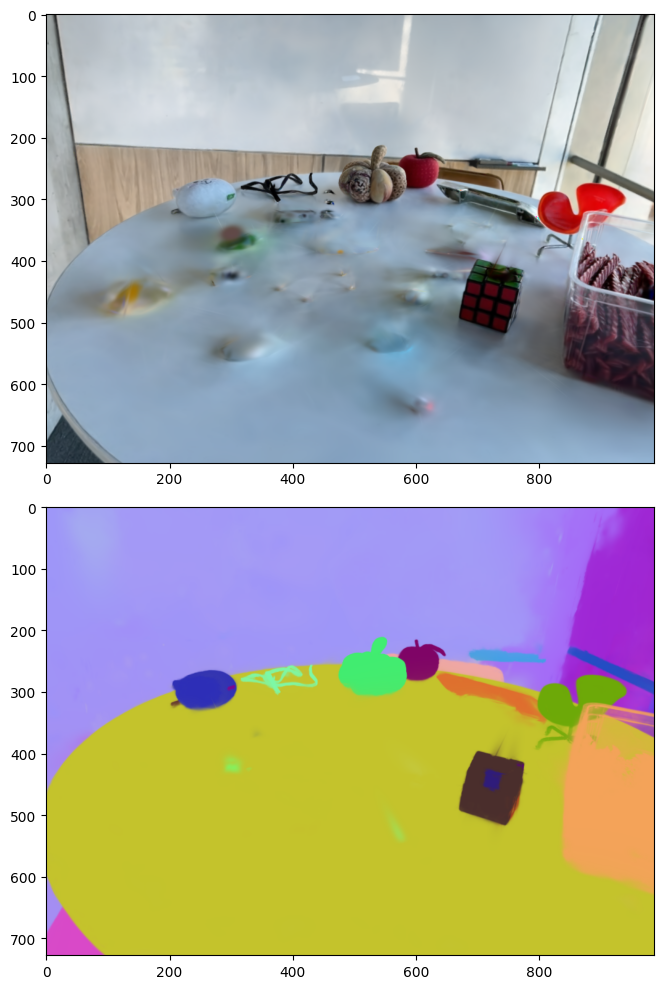

In [26]:
with torch.no_grad():
  r_pkg = render(train_views[19],
                 gaussians,
                 pipeline,
                 background,
                 opacity_mask=~child_mask)
  image = r_pkg["render"]
  img_semantic = r_pkg["feature"]

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(torchvision.transforms.ToPILImage()(image.cpu()))
plt.subplot(2, 1, 2)
plt.imshow(torchvision.transforms.ToPILImage()((img_semantic * .5 + .5).cpu()))
plt.tight_layout()
plt.show()

2025-11-24 12:34:15.175 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 0 selected 4493 edges, 1917 anchors
2025-11-24 12:34:15.177 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 1 selected 141302 edges, 3229 anchors
2025-11-24 12:34:15.179 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 2 selected 292341 edges, 2438 anchors
2025-11-24 12:34:15.181 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 3 selected 397884 edges, 2003 anchors
2025-11-24 12:34:15.183 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 4 selected 478366 edges, 1307 anchors
2025-11-24 12:34:15.185 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 5 selected 524942 edges, 691 anchors
2025-11-24 12:34:15.186 | INFO     | scene.utils.graph_baseclass:select_edges_via_graph_diffusion_:550 - iter 6 sel

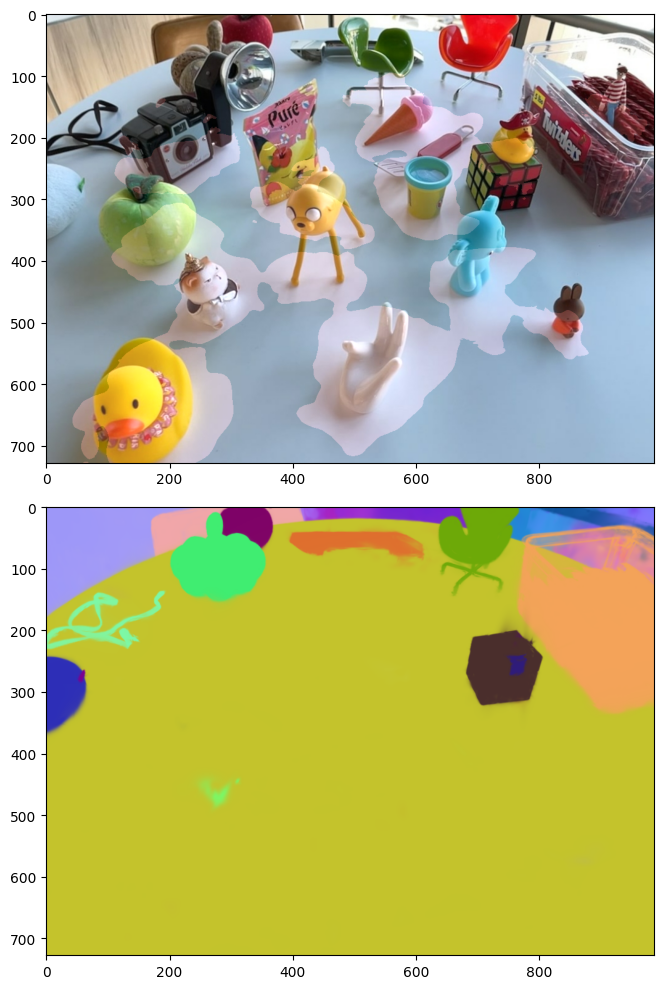

In [ ]:
selected_edges, selected_anchor, boundary_anchor = gaussians.GraphHelper.select_edges(
    idx,
    edge_weight_threshold=0.10,
    iter_num=50,
    edge_select_condition=lambda ew, threshold: ew < threshold,
    big_anchor_mask=None,
    return_boundary_anchor=True)

# selected_edges, selected_anchor = gaussians.GraphHelper.select_edges_via_graph_diffusion(
#     idx, feature_threshold=0.3, iter_num=20)

child_mask = selected_anchor[gaussians._point2anchor].contiguous()

boundary_anchor = boundary_anchor & (~selected_anchor)

boundary_child_mask = boundary_anchor[gaussians._point2anchor].contiguous()

# print(child_mask.shape)
boundary_color_xyz = torch.zeros_like(gaussians.get_xyz)
# boundary_color_xyz[boundary_child_mask | child_mask, :] = 1.0
boundary_color_xyz[boundary_child_mask, :] = 1.0

with torch.no_grad():
  r_pkg = render(target_view,
                 gaussians,
                 pipeline,
                 background_w,
                 override_color=boundary_color_xyz,
                 opacity_mask=~child_mask.unsqueeze(1))
  mask_np = (r_pkg["render"].mean(dim=0)
             > 0.2).float().cpu().numpy().astype(np.uint8)
  img_semantic = r_pkg["feature"]

  mask_padded = cv2.copyMakeBorder(mask_np,
                                   1,
                                   1,
                                   1,
                                   1,
                                   borderType=cv2.BORDER_CONSTANT,
                                   value=0)
  im_floodfill = mask_padded.copy()
  h, w = mask_padded.shape
  floodfill_mask = np.zeros((h + 2, w + 2), np.uint8)

  cv2.floodFill(im_floodfill, floodfill_mask, (0, 0), 255)
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  mask_filled = mask_padded | im_floodfill_inv

  mask_np_filled = mask_filled[1:-1, 1:-1]
  mask = torch.from_numpy(mask_np_filled).to(device).bool()

  mask = repeat(mask.unsqueeze(0), "1 h w -> b h w", b=3).float()

image = target_view.original_image.cuda() + torch.tensor(
    [1.0, 0.5, 0.5], device=device).unsqueeze(1).unsqueeze(2) * 0.2 * mask
image = torch.clamp(image, 0.0, 1.0)

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(torchvision.transforms.ToPILImage()(image.cpu()))
plt.subplot(2, 1, 2)
plt.imshow(torchvision.transforms.ToPILImage()(
    (img_semantic * 0.5 + 0.5).cpu()))
plt.tight_layout()
plt.show()
